In [1]:
import datetime
dateform = '%Y-%b-%d'
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/wenquanyi/wqy-microhei-lite/wqy-microhei-lite.ttc')
#plt.xlabel(u"横坐标xlabel",fontproperties=zhfont1)
%matplotlib inline
import re

## 前處理

將文章存成句子，載入新詞和helper function

In [2]:
f = open('NewWordDiscovery/all_article.txt','r')
arts = [x.strip().decode('utf8') for x in f]
arts = list(set(arts))

f = open('NewWordDiscovery/new_word_dict.csv','r')
newwords = [x.strip().decode('utf8').split(',')[0] for x in f][1:]

def takealook(word,output=False):
    count = 0
    for x in arts:
        if word in x:
            count+=1
            if output:
                print x
    return count

def get_date_count(word, arts,year='2015'):
    date2count = defaultdict(int)
    for idx, art in enumerate(arts):
        #print art.split('&&&')
        try:
            date_str = art.split('&&&')[1]
        except IndexError as e:
            pass
            #print 'fail to transform {idx}'.format(idx=idx)
        else:
            if word in art and date_str.split('-')[0]==year:
                try:
                    date = datetime.datetime.strptime(date_str,dateform)
                except ValueError as e:
                    print 'fail to transform the date string: {date_str}'.format(date_str=date_str)
                else:
                    count = 1#art.count(word)
                    date2count[date]+=count
    return date2count

## 詞彙

### 計算先前選詞的新詞在2015年政黑版出現的次數

In [3]:
#words_hypothesis.index#Load the time series of words we choose
new_words=[x.strip().decode('utf8') for x in open('NewWordDiscovery/input_word.txt')]
words2ts = {word:pd.Series(get_date_count(word,arts)) for word in new_words}
for x in words2ts:
    print x, words2ts[x].sum()

婉君 857
一身皺褶 3
綠衛兵 241
帶風向 2329
次元切割刀 14
大腸花 350
玻璃心 840
希望的種子 37
over my dead body 12
中壢李姓客倌 5
黃金切割 36
不自殺聲明 56
祭止兀 311
剩蚊 100
砂石倫 332
北連中胡 1106
香蕉 877
瘋吱谷 89
三七元 11
吹狗蕾 74
太陽餅 153
反黑箱 395
Z>B 83
馬卡茸 70
連公子 408
2.0 4698
政治素人 277
半分忠 181
割闌尾 233
洗洗睡 1328
太陽花 3184


### 載入問卷結果、換算分數

In [4]:
#Load hypothesis score
words_hypothesis = pd.read_csv('NewWordDiscovery/newword_hypothesis.csv')
words_hypothesis=words_hypothesis.drop(labels=0)
sour = { word: words_hypothesis['請問你認為，下列詞彙的「酸度」： [{word}]'.format(word=word.encode('utf8'))] for word in new_words}
sentility =  { word: words_hypothesis['請問你認為，下列詞彙可以任意被放在句子內造句的程度： [{word}]'.format(word=word.encode('utf8'))] for word in new_words}
metaphorlity = { word: words_hypothesis['請問你認為，下列詞彙帶有的隱喻程度： [{word}]'.format(word=word.encode('utf8'))] for word in new_words}
sour_term = {'非常酸':6,'酸':5,'有點酸':4,'有點不酸':3,'不酸':2,'非常不酸':1}
metaphorlity_term = {'非常高':6,'高':5,'有點高':4,'有點低':3,'低':2,'非常低':1}
sentility_term = {'非常高':6,'高':5,'有點高':4,'有點低':3,'低':2,'非常低':1}
hypothesis_terms = [sour_term, sentility_term, metaphorlity_term]
hypothesis = [sour, sentility, metaphorlity]
for h,ht in zip(hypothesis,hypothesis_terms):
    for x,y in h.items():
        h[x]=y.apply(lambda x: ht[x])
sour = pd.DataFrame(sour)
metaphorlity = pd.DataFrame(metaphorlity)
sentility = pd.DataFrame(sentility)

### 酸度

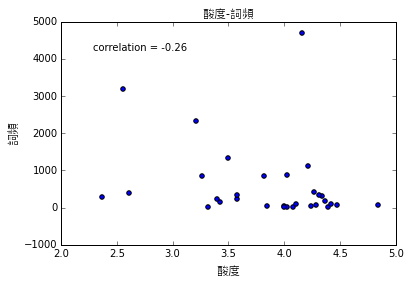

In [23]:
Y = [ts.sum() for word,ts in words2ts.items()]
#Y = pd.Series(Y)

sour_mean = sour.mean()
sourX = [ sour_mean[word] for word in words2ts]
rho =  pearsonr(sourX,Y)[0]
plt.scatter(sourX,Y)
plt.title(u'酸度-詞頻',fontproperties=zhfont1)
plt.xlabel(u'酸度',fontproperties=zhfont1)
plt.ylabel(u'詞頻',fontproperties=zhfont1)
plt.figtext(0.2,0.8,'correlation = {rho:.2f}'.format(rho=rho))


### 可被任意用在句子中的程度

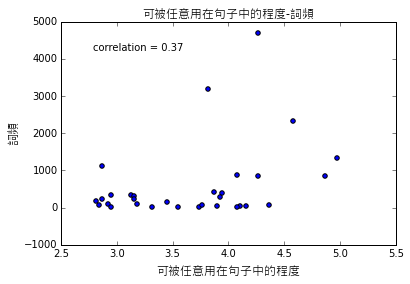

In [20]:
sentility_mean = sentility.mean()
sentilityX = [ sentility_mean[word] for word in words2ts]
rho = pearsonr(sentilityX,Y)[0]
plt.scatter(sentilityX,Y)
plt.title(u'可被任意用在句子中的程度-詞頻',fontproperties=zhfont1)
plt.xlabel(u'可被任意用在句子中的程度',fontproperties=zhfont1)
plt.ylabel(u'詞頻',fontproperties=zhfont1)
plt.figtext(0.2,0.8,'correlation = {rho:.2f}'.format(rho=rho))

### 隱喻程度

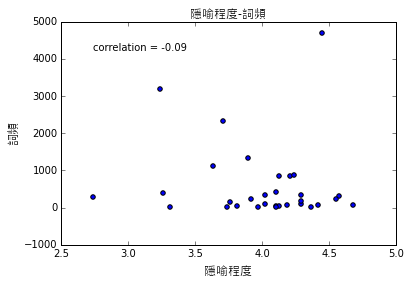

In [24]:
metaphorlity_mean = metaphorlity.mean()
metaphorlityX = [ metaphorlity_mean[word] for word in words2ts]
rho =  pearsonr(metaphorlityX,Y)[0]
plt.scatter(metaphorlityX,Y)
plt.title(u'隱喻程度-詞頻',fontproperties=zhfont1)
plt.xlabel(u'隱喻程度',fontproperties=zhfont1)
plt.ylabel(u'詞頻',fontproperties=zhfont1)
plt.figtext(0.2,0.8,'correlation = {rho:.2f}'.format(rho=rho))

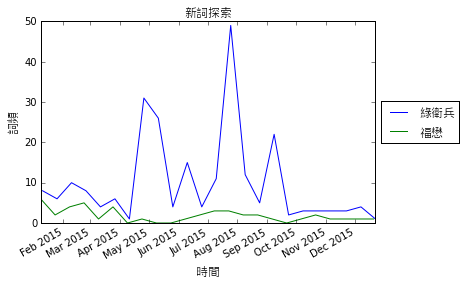

## 句子

In [27]:
new_sents = [x.strip().decode('utf8') for x in open('NewWordDiscovery/input_sent.txt')]
#get sentences time series
sent_keywords=[u'臺灣不會好',u'自己救',u'我還以為是',u'就是義務',u'我有一個請求'
               ,u'唯一支持',u'請退選',u'什麼才是',u'別讓',u'裡沒有',u'水退了',u'無限期支持']
sent_ts = {new_sents[idx]:pd.Series(get_date_count(word,arts)) for idx, word in enumerate(sent_keywords)}
sents_hypothesis = pd.read_csv('NewWordDiscovery/newsent_hypothesis.csv')
#sents_hypothesis= sent_hypothesis.drop(labels=0)
easy2know = { sent: sents_hypothesis['請問你認為，下列語句易於理解的程度： [{sent}]'.format(sent=sent.encode('utf8'))] for sent in new_sents}
easy2talk = { sent: sents_hypothesis['請問你認為，下列語句的順口程度： [{sent}]'.format(sent=sent.encode('utf8'))] for sent in new_sents}
easy2makesents = { sent: sents_hypothesis['請問你認為，下列語句可用來照樣造句的程度： [{sent}]'.format(sent=sent.encode('utf8'))] for sent in new_sents}

terms = {'非常高':6,'高':5,'有點高':4,'有點低':3,'低':2,'非常低':1}
#sentility_term = {'非常高':6,'高':5,'有點高':4,'有點低':3,'低':2,'非常低':1}
#hypothesis_terms = [sour_term, sentility_term, metaphorlity_term]
hypothesis = [easy2know, easy2talk, easy2makesents]
for h in hypothesis:
    for x,y in h.items():
        h[x]=y.apply(lambda x: terms[x])
easy2know = pd.DataFrame(easy2know)
easy2talk = pd.DataFrame(easy2talk)
easy2makesents = pd.DataFrame(easy2makesents)

### 易於理解程度

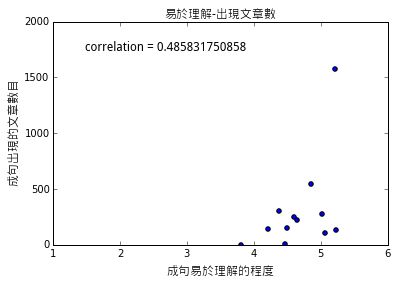

In [28]:
Y=[ts.sum() for word, ts in sent_ts.items()]
X=[easy2know[word].mean() for word, _ in sent_ts.items()]
plt.scatter(X,Y)
plt.axis([1,6,0,2000])
plt.xlabel(u'成句易於理解的程度',fontproperties=zhfont1)
plt.ylabel(u'成句出現的文章數目',fontproperties=zhfont1)
plt.title(u'易於理解-出現文章數',fontproperties=zhfont1)
rho=sp.stats.pearsonr(X,Y)
plt.figtext(0.20,0.80,'correlation = {rho}'.format(rho=rho[0]),fontproperties=zhfont1)

### 順口程度

(0.34044577402538906, 0.27888118315868965)


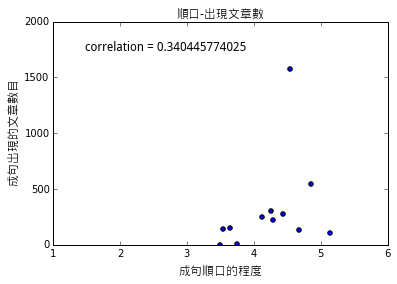

In [29]:
Y=[ts.sum() for word, ts in sent_ts.items()]
#for idx, word in enumerate(sent_ts):
  #  print word, Y[idx]
X=[easy2talk[word].mean() for word, _ in sent_ts.items()]
#plt.axis([0,6,0,4000])
print sp.stats.pearsonr(X,Y)
plt.scatter(X,Y)
plt.axis([1,6,0,2000])
plt.xlabel(u'成句順口的程度',fontproperties=zhfont1)
plt.ylabel(u'成句出現的文章數目',fontproperties=zhfont1)
plt.title(u'順口-出現文章數',fontproperties=zhfont1)
rho=sp.stats.pearsonr(X,Y)
plt.figtext(0.20,0.80,'correlation = {rho}'.format(rho=rho[0]),fontproperties=zhfont1)

### 可照樣造句程度

(0.34467500859928624, 0.27256404249303379)


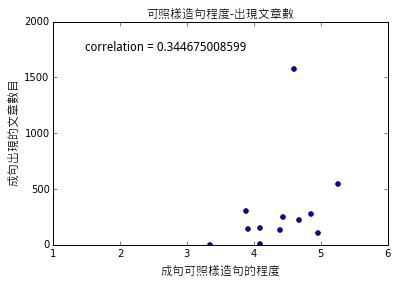

In [30]:
Y=[ts.sum() for word, ts in sent_ts.items()]
X=[easy2makesents[word].mean() for word, _ in sent_ts.items()]
print sp.stats.pearsonr(X,Y)
#plt.axis([0,6,0,4000])
plt.scatter(X,Y)
plt.axis([1,6,0,2000])
plt.xlabel(u'成句可照樣造句的程度',fontproperties=zhfont1)
plt.ylabel(u'成句出現的文章數目',fontproperties=zhfont1)
plt.title(u'可照樣造句程度-出現文章數',fontproperties=zhfont1)
rho=sp.stats.pearsonr(X,Y)
plt.figtext(0.20,0.80,'correlation = {rho}'.format(rho=rho[0]),fontproperties=zhfont1)
#for i, word in enumerate(sent_ts):
  #  plt.annotate(word, (X[i],Y[i]),fontproperties=zhfont1)